In [1]:
import numpy as np
import pandas as pd
import csv
import pickle
import math
import cmath
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from random import randint
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import scipy as sp
from os.path import dirname, join as pjoin
import scipy.io as sio
from matplotlib import mlab
from tqdm import tqdm
import time
import pathlib
import csv
import os
import warnings
warnings.filterwarnings("ignore")
import glob

/shared/centos7/anaconda3/2022.05/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
print(os.getcwd())
directory='/home/zandi.r/Data/8 Class/'

/home/zandi.r/Data


In [4]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    #plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=20)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]



    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]*100),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]*100),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylim(len(target_names)-0.5, -0.5)
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.savefig(title + '.png', dpi=500, bbox_inches = 'tight')
    plt.show()


In [5]:
def get_CSIs(directory, train_speeds, test_speed):
    CSIs = []
    Labels = []
    CSIs_test = []
    Labels_test = []

    for labels in os.listdir(directory):  # Main Directory where each class label is present as a folder name.
        label_path = os.path.join(directory, labels)
        if os.path.isdir(label_path):
            if labels == 'Arc':  # Folder contains ARCXZ CSIs get the '0' class label.
                label = 0
            elif labels == 'Elbow':
                label = 1
            elif labels == 'Rectangle':
                label = 2
            elif labels == 'Silence':
                label = 3  
            elif labels == 'SLFW':
                label = 4
            elif labels == 'SLRL':
                label = 5
            elif labels == 'SLUD':
                label = 6
            elif labels == 'Triangle':
                label = 7

            # Get a list of speeds in the label directory
            speed_folders = os.listdir(label_path)
            for speed_folder in speed_folders:
                if speed_folder in train_speeds:
                    data_type = 'train'
                elif speed_folder == test_speed:
                    data_type = 'test'
                else:
                    continue

                speed_path = os.path.join(label_path, speed_folder)
                for csi_file in os.listdir(speed_path):  # Extracting the file name of the csi from Speed folder
                    if csi_file == '.DS_Store':
                        continue  # Skip processing this file
                    def read_file(filename):
                        with open(filename, 'rb') as FID:
                            mp = pickle.Unpickler(FID)
                            data = mp.load()
                        return data

                    csi = read_file(os.path.join(speed_path, csi_file))  # Reading the csi
                    ar1 = np.asmatrix(np.abs(csi[0]['complex_csi']))
                    arr1 = np.delete(ar1, [0, 1, 2, 3, 4, 115, 116, 117, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 253, 254, 255], 1)
                    arr1 = np.pad(arr1, ((0, 0), (64, 64)), mode='constant')

                    ar2 = np.asmatrix(np.abs(csi[1]['complex_csi']))
                    arr2 = np.delete(ar2, [0, 1, 2, 3, 4, 115, 116, 117, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 253, 254, 255], 1)
                    arr2 = np.pad(arr2, ((0, 0), (64, 64)), mode='constant')

                    arr = np.concatenate((arr1, arr2), axis=1)

                    # Append to the dataset based on data_type
                    if data_type == 'train':
                        # Append to training data
                        CSIs.append(arr)
                        Labels.append(label)
                    elif data_type == 'test':
                        # Append to testing data
                        CSIs_test.append(arr)
                        Labels_test.append(label)

    return shuffle(CSIs, Labels, random_state=817328462), shuffle(CSIs_test, Labels_test, random_state=817328462)

# def get_classlabel(class_code):
#     labels = {0: 'ARC', 1: 'DIAG_XY', 2: 'Elbow', 3: 'Rectangle', 4: 'Silence', 5: 'SLFW', 6: 'SLRL', 7: 'SLUD'}
#     return labels[class_code]

In [6]:
# Define train and test speeds
train_speeds = ['V1','V3']  # Two speeds for training
test_speed = 'V2'  # One speed for testing

# Call the function to get training and testing data
training_data, testing_data = get_CSIs(directory, train_speeds, test_speed)

# Separate training and testing data
train_CSIs, train_labels = training_data
test_CSIs, test_labels = testing_data


In [7]:
train_CSIs=np.array(train_CSIs)
train_labels=np.array(train_labels)
print("Shape of Images:",train_CSIs.shape)
print("Shape of Labels:",train_labels.shape)

Shape of Images: (368, 360, 720)
Shape of Labels: (368,)


In [8]:
Test=np.array(test_CSIs)
Test_labels=np.array(test_labels)
print("Shape of Images:",Test.shape)
print("Shape of Labels:",Test_labels.shape)

Shape of Images: (184, 360, 720)
Shape of Labels: (184,)


In [9]:
train_CSIs[0].shape

(360, 720)

In [10]:
np.count_nonzero(Test_labels==0)

23

In [11]:
Train, Validation, Train_labels, Validation_labels = train_test_split(train_CSIs,train_labels, test_size=0.2, shuffle=True)

In [12]:
def split_data(data, labels):
    # Split the data into two matrices of size 400x400 each
    data1 = data[:, :, :360]
    data2 = data[:, :, 360:720]

    return data1, data2, labels

Train1, Train2, Train_labels = split_data(Train, Train_labels)
Validation1, Validation2, Validation_labels = split_data(Validation, Validation_labels)
Test1, Test2, Test_labels = split_data(Test, Test_labels)

In [13]:
Train1.shape

(294, 360, 360)

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

In [15]:
# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, images1, images2, labels, patch_size):
        self.images1 = images1
        self.images2 = images2
        self.labels = labels
        self.patch_size = patch_size

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image1 = self.images1[idx]
        image2 = self.images2[idx]
        label = self.labels[idx]
        image1 = np.expand_dims(image1, axis=0)  # Add channel dimension
        image2 = np.expand_dims(image2, axis=0)  # Add channel dimension
        patches1 = self.patchify(image1, self.patch_size)
        patches2 = self.patchify(image2, self.patch_size)
        #print(f'patches {patches1.shape}')
        return patches1, patches2, label


    def patchify(self, image, patch_size):
        Channel, height, width = image.shape  # Get height and width of the image
        patches = []
        for i in range(0, height, patch_size):
            for j in range(0, width, patch_size):
                patch = image[:, i:i+patch_size, j:j+patch_size]
                patches.append(patch)
        return np.concatenate(patches, axis=0)



class VisionTransformer(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, num_layers, patch_size, num_channels, num_classes, dropout):
        super(VisionTransformer, self).__init__()
        self.embedding = nn.Linear(patch_size * patch_size * num_channels, embed_dim)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads),
            num_layers=num_layers
        )
        self.fc = nn.Linear(embed_dim, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size, num_patches, _, _ = x.size()
        x = x.view(batch_size * num_patches, -1)
        x = self.embedding(x)
        x = x.view(batch_size, num_patches, -1)
        x = x.permute(1, 0, 2)
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2)
        x = x.mean(dim=1)
        x = self.dropout(x)
        x = self.fc(x)
        return x



In [16]:
# Define the vision transformers and other parameters
embed_dim1 = 256
embed_dim2 = 256
embed_dim=256
hidden_dim = 256 * 3
num_channels = 1
batch_size = 32
num_heads = 4
num_layers = 6
patch_size = 45
num_classes =8
dropout = 0.4
epochs=100
learning_rate=0.0001
weight_decay=0.00002

In [17]:
# Convert data to PyTorch tensors
Train1 = torch.tensor(Train1, dtype=torch.float32)
Train2 = torch.tensor(Train2, dtype=torch.float32)
Train_labels = torch.tensor(Train_labels, dtype=torch.long)

Test1 = torch.tensor(Test1, dtype=torch.float32)
Test2 = torch.tensor(Test2, dtype=torch.float32)
Test_labels = torch.tensor(Test_labels, dtype=torch.long)

Validation1 = torch.tensor(Validation1, dtype=torch.float32)
Validation2 = torch.tensor(Validation2, dtype=torch.float32)
Validation_labels = torch.tensor(Validation_labels, dtype=torch.long)

# Create custom datasets
train_dataset = CustomDataset(Train1, Train2, Train_labels, patch_size)
test_dataset = CustomDataset(Test1, Test2, Test_labels, patch_size)
val_dataset = CustomDataset(Validation1, Validation2, Validation_labels, patch_size)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

class CombinedModel(nn.Module):
    def __init__(self, vision_transformer1, vision_transformer2, num_classes):
        super(CombinedModel, self).__init__()
        self.vision_transformer1 = vision_transformer1
        self.vision_transformer2 = vision_transformer2
        self.flatten = nn.Flatten()  # Add a flatten layer
        
        # Adjust the input size of the fc layer based on the output size after flattening
        self.fc = nn.Linear(2*num_classes , num_classes)
        
    def forward(self, patches1, patches2):
        features1 = self.vision_transformer1(patches1)
        features2 = self.vision_transformer2(patches2)
        # Apply the flatten layer to the output of the Vision Transformers
        features1 = self.flatten(features1)
        features2 = self.flatten(features2)

        # Concatenate the two tensors together
        combined_features = torch.cat((features1, features2), dim=1)
        output = self.fc(combined_features)
        return output

vision_transformer1 = VisionTransformer(embed_dim1, hidden_dim, num_heads, num_layers, patch_size, num_channels,num_classes, dropout)
vision_transformer2 = VisionTransformer(embed_dim2, hidden_dim, num_heads, num_layers, patch_size, num_channels, num_classes, dropout)

combined_model = CombinedModel(vision_transformer1, vision_transformer2, num_classes)

# Model and Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
combined_model.to(device)
class_weights = torch.tensor([1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.float32).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(combined_model.parameters(), lr=learning_rate, weight_decay=weight_decay)


# Training loop with early stopping
early_stopping_patience = 15
best_val_loss = float('inf')
wait = 0

for epoch in range(epochs):
    combined_model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} Training", ncols=100)
    
    for patches1, patches2, labels in train_bar:
        patches1, patches2, labels = patches1.to(device), patches2.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = combined_model(patches1, patches2)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        train_bar.set_postfix({"Loss": train_loss/len(train_bar), "Acc": 100.0*correct/total})
    
    train_loss /= len(train_loader)
    train_acc = 100.0 * correct / total
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.2f}%")
    
    # Validation
    combined_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for patches1, patches2, labels in val_loader:
            patches1, patches2, labels = patches1.to(device), patches2.to(device), labels.to(device)
            outputs = combined_model(patches1, patches2)
            val_loss += loss_fn(outputs, labels).item()
            
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_loss /= len(val_loader)
    val_acc = 100.0 * correct / total
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.2f}%")
    print('________________________________________________________________________')
    
    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
    else:
        wait += 1
        if wait >= early_stopping_patience:
            print("Early stopping triggered. Training stopped.")
            break

True


Epoch 1 Training: 100%|████████████████████████| 19/19 [00:01<00:00, 13.19it/s, Loss=2.15, Acc=14.3]


Epoch 1, Train Loss: 2.1451 | Train Accuracy: 14.29%
Validation Loss: 2.0753 | Validation Accuracy: 27.03%
________________________________________________________________________


Epoch 2 Training: 100%|████████████████████████| 19/19 [00:00<00:00, 25.65it/s, Loss=2.14, Acc=13.9]


Epoch 2, Train Loss: 2.1447 | Train Accuracy: 13.95%
Validation Loss: 2.0382 | Validation Accuracy: 25.68%
________________________________________________________________________


Epoch 3 Training: 100%|████████████████████████| 19/19 [00:00<00:00, 24.94it/s, Loss=1.94, Acc=24.5]


Epoch 3, Train Loss: 1.9369 | Train Accuracy: 24.49%
Validation Loss: 1.8859 | Validation Accuracy: 28.38%
________________________________________________________________________


Epoch 4 Training: 100%|████████████████████████| 19/19 [00:09<00:00,  1.98it/s, Loss=1.83, Acc=31.3]


Epoch 4, Train Loss: 1.8304 | Train Accuracy: 31.29%
Validation Loss: 1.6937 | Validation Accuracy: 47.30%
________________________________________________________________________


Epoch 5 Training: 100%|████████████████████████| 19/19 [00:16<00:00,  1.16it/s, Loss=1.47, Acc=43.9]


Epoch 5, Train Loss: 1.4701 | Train Accuracy: 43.88%
Validation Loss: 1.5022 | Validation Accuracy: 36.49%
________________________________________________________________________


Epoch 6 Training: 100%|██████████████████████████| 19/19 [00:10<00:00,  1.80it/s, Loss=1.29, Acc=48]


Epoch 6, Train Loss: 1.2893 | Train Accuracy: 47.96%
Validation Loss: 1.1539 | Validation Accuracy: 52.70%
________________________________________________________________________


Epoch 7 Training: 100%|███████████████████████| 19/19 [00:16<00:00,  1.16it/s, Loss=0.995, Acc=61.9]


Epoch 7, Train Loss: 0.9949 | Train Accuracy: 61.90%
Validation Loss: 0.9668 | Validation Accuracy: 60.81%
________________________________________________________________________


Epoch 8 Training: 100%|███████████████████████| 19/19 [00:16<00:00,  1.17it/s, Loss=0.781, Acc=72.8]


Epoch 8, Train Loss: 0.7807 | Train Accuracy: 72.79%
Validation Loss: 1.2826 | Validation Accuracy: 51.35%
________________________________________________________________________


Epoch 9 Training: 100%|███████████████████████| 19/19 [00:02<00:00,  6.52it/s, Loss=0.876, Acc=64.3]


Epoch 9, Train Loss: 0.8761 | Train Accuracy: 64.29%
Validation Loss: 0.8824 | Validation Accuracy: 54.05%
________________________________________________________________________


Epoch 10 Training: 100%|██████████████████████| 19/19 [00:15<00:00,  1.19it/s, Loss=0.758, Acc=70.1]


Epoch 10, Train Loss: 0.7577 | Train Accuracy: 70.07%
Validation Loss: 0.6941 | Validation Accuracy: 72.97%
________________________________________________________________________


Epoch 11 Training: 100%|██████████████████████| 19/19 [00:16<00:00,  1.17it/s, Loss=0.605, Acc=77.9]


Epoch 11, Train Loss: 0.6049 | Train Accuracy: 77.89%
Validation Loss: 0.5742 | Validation Accuracy: 89.19%
________________________________________________________________________


Epoch 12 Training: 100%|██████████████████████| 19/19 [00:16<00:00,  1.18it/s, Loss=0.429, Acc=86.4]


Epoch 12, Train Loss: 0.4291 | Train Accuracy: 86.39%
Validation Loss: 0.4846 | Validation Accuracy: 85.14%
________________________________________________________________________


Epoch 13 Training: 100%|██████████████████████| 19/19 [00:16<00:00,  1.18it/s, Loss=0.386, Acc=88.4]


Epoch 13, Train Loss: 0.3860 | Train Accuracy: 88.44%
Validation Loss: 0.4843 | Validation Accuracy: 85.14%
________________________________________________________________________


Epoch 14 Training: 100%|██████████████████████| 19/19 [00:16<00:00,  1.17it/s, Loss=0.453, Acc=83.7]


Epoch 14, Train Loss: 0.4531 | Train Accuracy: 83.67%
Validation Loss: 0.5839 | Validation Accuracy: 81.08%
________________________________________________________________________


Epoch 15 Training: 100%|███████████████████████| 19/19 [00:01<00:00, 12.37it/s, Loss=0.49, Acc=82.3]


Epoch 15, Train Loss: 0.4898 | Train Accuracy: 82.31%
Validation Loss: 1.4392 | Validation Accuracy: 45.95%
________________________________________________________________________


Epoch 16 Training: 100%|██████████████████████| 19/19 [00:00<00:00, 24.20it/s, Loss=0.787, Acc=71.4]


Epoch 16, Train Loss: 0.7867 | Train Accuracy: 71.43%
Validation Loss: 0.4520 | Validation Accuracy: 82.43%
________________________________________________________________________


Epoch 17 Training: 100%|███████████████████████| 19/19 [00:00<00:00, 24.71it/s, Loss=0.47, Acc=84.7]


Epoch 17, Train Loss: 0.4700 | Train Accuracy: 84.69%
Validation Loss: 0.7569 | Validation Accuracy: 67.57%
________________________________________________________________________


Epoch 18 Training: 100%|██████████████████████| 19/19 [00:00<00:00, 25.18it/s, Loss=0.488, Acc=83.3]


Epoch 18, Train Loss: 0.4884 | Train Accuracy: 83.33%
Validation Loss: 0.4010 | Validation Accuracy: 89.19%
________________________________________________________________________


Epoch 19 Training: 100%|██████████████████████| 19/19 [00:00<00:00, 21.88it/s, Loss=0.235, Acc=93.9]


Epoch 19, Train Loss: 0.2348 | Train Accuracy: 93.88%
Validation Loss: 0.5305 | Validation Accuracy: 87.84%
________________________________________________________________________


Epoch 20 Training: 100%|██████████████████████| 19/19 [00:00<00:00, 25.21it/s, Loss=0.282, Acc=91.8]


Epoch 20, Train Loss: 0.2824 | Train Accuracy: 91.84%
Validation Loss: 0.2680 | Validation Accuracy: 93.24%
________________________________________________________________________


Epoch 21 Training: 100%|██████████████████████| 19/19 [00:00<00:00, 24.91it/s, Loss=0.235, Acc=92.5]


Epoch 21, Train Loss: 0.2346 | Train Accuracy: 92.52%
Validation Loss: 0.2487 | Validation Accuracy: 90.54%
________________________________________________________________________


Epoch 22 Training: 100%|██████████████████████| 19/19 [00:00<00:00, 24.50it/s, Loss=0.285, Acc=90.5]


Epoch 22, Train Loss: 0.2849 | Train Accuracy: 90.48%
Validation Loss: 0.3743 | Validation Accuracy: 90.54%
________________________________________________________________________


Epoch 23 Training: 100%|██████████████████████| 19/19 [00:00<00:00, 25.26it/s, Loss=0.228, Acc=92.2]


Epoch 23, Train Loss: 0.2282 | Train Accuracy: 92.18%
Validation Loss: 0.3131 | Validation Accuracy: 89.19%
________________________________________________________________________


Epoch 24 Training: 100%|██████████████████████| 19/19 [00:00<00:00, 25.01it/s, Loss=0.223, Acc=93.5]


Epoch 24, Train Loss: 0.2227 | Train Accuracy: 93.54%
Validation Loss: 0.1931 | Validation Accuracy: 94.59%
________________________________________________________________________


Epoch 25 Training: 100%|██████████████████████| 19/19 [00:00<00:00, 25.43it/s, Loss=0.182, Acc=95.6]


Epoch 25, Train Loss: 0.1818 | Train Accuracy: 95.58%
Validation Loss: 0.3114 | Validation Accuracy: 93.24%
________________________________________________________________________


Epoch 26 Training: 100%|██████████████████████| 19/19 [00:00<00:00, 25.30it/s, Loss=0.171, Acc=94.2]


Epoch 26, Train Loss: 0.1714 | Train Accuracy: 94.22%
Validation Loss: 0.3267 | Validation Accuracy: 87.84%
________________________________________________________________________


Epoch 27 Training: 100%|██████████████████████| 19/19 [00:00<00:00, 24.53it/s, Loss=0.208, Acc=94.6]


Epoch 27, Train Loss: 0.2079 | Train Accuracy: 94.56%
Validation Loss: 0.2247 | Validation Accuracy: 93.24%
________________________________________________________________________


Epoch 28 Training: 100%|██████████████████████| 19/19 [00:00<00:00, 24.14it/s, Loss=0.165, Acc=95.6]


Epoch 28, Train Loss: 0.1650 | Train Accuracy: 95.58%
Validation Loss: 0.1329 | Validation Accuracy: 97.30%
________________________________________________________________________


Epoch 29 Training: 100%|█████████████████████| 19/19 [00:00<00:00, 25.11it/s, Loss=0.0947, Acc=98.3]


Epoch 29, Train Loss: 0.0947 | Train Accuracy: 98.30%
Validation Loss: 0.1197 | Validation Accuracy: 97.30%
________________________________________________________________________


Epoch 30 Training: 100%|██████████████████████| 19/19 [00:00<00:00, 25.22it/s, Loss=0.093, Acc=98.3]


Epoch 30, Train Loss: 0.0930 | Train Accuracy: 98.30%
Validation Loss: 0.1798 | Validation Accuracy: 91.89%
________________________________________________________________________


Epoch 31 Training: 100%|██████████████████████| 19/19 [00:00<00:00, 25.31it/s, Loss=0.368, Acc=88.1]


Epoch 31, Train Loss: 0.3676 | Train Accuracy: 88.10%
Validation Loss: 0.3579 | Validation Accuracy: 86.49%
________________________________________________________________________


Epoch 32 Training: 100%|██████████████████████| 19/19 [00:00<00:00, 23.23it/s, Loss=0.211, Acc=94.6]


Epoch 32, Train Loss: 0.2108 | Train Accuracy: 94.56%
Validation Loss: 0.1545 | Validation Accuracy: 94.59%
________________________________________________________________________


Epoch 33 Training: 100%|██████████████████████| 19/19 [00:04<00:00,  4.27it/s, Loss=0.104, Acc=98.3]


Epoch 33, Train Loss: 0.1037 | Train Accuracy: 98.30%
Validation Loss: 0.1908 | Validation Accuracy: 95.95%
________________________________________________________________________


Epoch 34 Training: 100%|█████████████████████| 19/19 [00:16<00:00,  1.16it/s, Loss=0.0922, Acc=98.6]


Epoch 34, Train Loss: 0.0922 | Train Accuracy: 98.64%
Validation Loss: 0.1813 | Validation Accuracy: 95.95%
________________________________________________________________________


Epoch 35 Training: 100%|█████████████████████| 19/19 [00:16<00:00,  1.18it/s, Loss=0.0485, Acc=99.7]


Epoch 35, Train Loss: 0.0485 | Train Accuracy: 99.66%
Validation Loss: 0.1553 | Validation Accuracy: 97.30%
________________________________________________________________________


Epoch 36 Training: 100%|█████████████████████| 19/19 [00:16<00:00,  1.17it/s, Loss=0.0389, Acc=99.7]


Epoch 36, Train Loss: 0.0389 | Train Accuracy: 99.66%
Validation Loss: 0.1407 | Validation Accuracy: 97.30%
________________________________________________________________________


Epoch 37 Training: 100%|█████████████████████| 19/19 [00:16<00:00,  1.18it/s, Loss=0.0397, Acc=99.3]


Epoch 37, Train Loss: 0.0397 | Train Accuracy: 99.32%
Validation Loss: 0.1622 | Validation Accuracy: 95.95%
________________________________________________________________________


Epoch 38 Training: 100%|█████████████████████| 19/19 [00:16<00:00,  1.18it/s, Loss=0.0466, Acc=99.3]


Epoch 38, Train Loss: 0.0466 | Train Accuracy: 99.32%
Validation Loss: 0.1618 | Validation Accuracy: 97.30%
________________________________________________________________________


Epoch 39 Training: 100%|█████████████████████| 19/19 [00:16<00:00,  1.18it/s, Loss=0.0341, Acc=99.7]


Epoch 39, Train Loss: 0.0341 | Train Accuracy: 99.66%
Validation Loss: 0.2193 | Validation Accuracy: 93.24%
________________________________________________________________________


Epoch 40 Training: 100%|█████████████████████| 19/19 [00:10<00:00,  1.80it/s, Loss=0.0249, Acc=99.7]


Epoch 40, Train Loss: 0.0249 | Train Accuracy: 99.66%
Validation Loss: 0.2100 | Validation Accuracy: 95.95%
________________________________________________________________________


Test Loss: 0.5208 | Test Accuracy: 90.76%


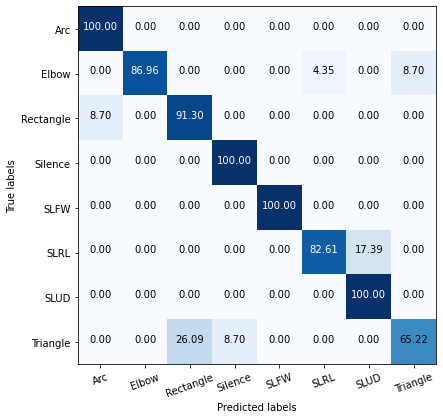

              precision    recall  f1-score   support

         Arc     0.9200    1.0000    0.9583        23
       Elbow     1.0000    0.8696    0.9302        23
   Rectangle     0.7778    0.9130    0.8400        23
     Silence     0.9200    1.0000    0.9583        23
        SLFW     1.0000    1.0000    1.0000        23
        SLRL     0.9500    0.8261    0.8837        23
        SLUD     0.8519    1.0000    0.9200        23
    Triangle     0.8824    0.6522    0.7500        23

    accuracy                         0.9076       184
   macro avg     0.9127    0.9076    0.9051       184
weighted avg     0.9127    0.9076    0.9051       184



In [81]:
# Testing
combined_model.eval()
test_loss = 0.0
correct, total = 0, 0
predictions = []
ground_truths = []

with torch.no_grad():
    for patches1, patches2, labels in test_loader:
        patches1, patches2, labels = patches1.to(device), patches2.to(device), labels.to(device)
        outputs = combined_model(patches1, patches2)
        test_loss += loss_fn(outputs, labels).item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        predictions.extend(predicted.tolist())
        ground_truths.extend(labels.tolist())
 
test_loss /= len(test_loader)
test_acc = 100.0 * correct / total
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")
labels = ['Arc', 'Elbow', 'Rectangle', 'Silence','SLFW', 'SLRL', 'SLUD', 'Triangle']
cfm = confusion_matrix(ground_truths, predictions)
cfm6=cfm